# Mixed Signals - soil bioturbation simulation tool
Author: W. Marijn van der Meij<br>
2024<br>
Version 1.0<br>
***
This Jupyter Notebook contains the code and examples for running the Mixed Signal model, a numerical model for simulating different bioturbation processes and their effect on luminescence tracers. The code is written in the Julia programming language.

The use cases of this model are described in the accompanying paper `Mixed signals - interpreting soil mixing patterns by different biota through luminescence and numerical modelling`, by W.M. van der Meij, S. Riedesel and T Reimann (2024) [DOI]. This Jupyter Notebook will guide you through different uses of the model, which are the simulation of different bioturbation processes, process interactions, runs with varying parameters and the calibration of luminescence-based depth profiles using the model. The required functions to run the model are stored in the file `Mixed-Signals_functions.jl`.

The luminescence-based depth profiles are presented in three metrics:
- The modal age of the age distributions, as the most probable age of each layer
- The interquartile range, as a measure of the width of the distribution
- the bioturbated fraction, as a measure of the fraction of bleached (i.e. bioturbated) particles in each layer. 

## Prepare workspace
The functions for the simulations are stored in the `Mixed-signals_functions.jl` file. You can open this file separately to look at, or modify, the code. For this notebook, you can run the code below to load the functions and the required packages. The first time that you run this line will take a while, as all the required packages need to be installed. The packages will be installed in the project folder, where this notebook is also stored. 

In [13]:
include("Mixed-Signals_functions.jl")

#151 (generic function with 1 method)

## Define parameters
In the code below, the parameters are defined. The first block contains the parameters for defining the soil and luminescence tracers. The second block contains the parameters that determine process behaviour. The soil profile is represented by a matrix with a specified number of soil layers. With the parameters below, the soil is 2 meters deep and initially contains 100 soil layers of 2 cm thick. The uppermost layer of 5 mm is the layer where particles are bleached and their burial ages are set to zero. Every layer initially contains 150 luminescence particles. Each layer has a specified bulk density of 1500 kg $m^{-3}$. 

Through the transfer of soil mass during the simulations, the soil layer thicknesses and their number of luminescence particles will change. When layers get too thin or too thick (55% more or less that the initial thickness), they are either merged with neighbouring layers or split into two separate layers. These dynamic layer thicknesses enable an accurate simulation of additions and removals and their effect on layer thickness. When splitting and merging, the luminescence particles will also be divided or combined. The luminescence particles are stored in an array of arrays, which are able to store variable numbers of luminescence particles for each layer. 

In [2]:
## Define objects and parameters for soil and luminescence
bd = 1500               # Bulk density [kg m⁻³]
soildepth = 2           # Thickness of the entire soil profile [m]
nlayers = 100           # Number of soil layers
layer_thickness = 0.02  # Initial layer thickness [m]
bleaching_depth = 0.005 # Thickness of surface layer where bleaching occurs [m]
grains_per_layer = 150  # Initial number of layers per soil layer

# Define process-specific parameters 
BT_pot = 10             # Potential bioturbation rate [kg m⁻² a⁻¹]
dd = 1                  # Depth parameter [m⁻¹]
dd_exch = 10            # Depth parameter for subsurface mixing [m⁻¹]
ntime = 10000           # Number of simulation years


10000

## Simulation run with mounding
The code below simulates the mounding process using the parameters set above. The first line of code creates the objects `soil` and `ages`, using the parameters defined above. These objects are arrays that store the information on soil layer thickness and the luminescence tracers. 

The next part of the code iterates over the amount of timesteps. Every timestep, an event of mounding is simulated and the `soil` and `ages` objects are updated. `@showprogress` is a tool that adds a progress bar at the bottom of the code block.

The function `BT_mounding()` simulates the actual mounding process. The inputs for this function are the `soil` and `ages` objects resulting from the 'initialise_soil' function. These are updated each calculation step. The third argument is the potential bioturbation rate, the fourth argument is the depth function and the fifth argument is the depth decay parameter, which defines the depth of the active mixing layer.  

The options for the depth functions are:
- "grd": gradational or linearly decreasing rate with depth
- "exp": exponentially decreasing rate with depth
- "abr": uniform mixing rates in the active mixing zone, with an abrupt decrease to zero below.

The function `update_soil_and_luminescence()` updates soil properties and luminescence ages after each bioturbation run. This code updates layer thicknesses, adds a year to all luminescence ages and resets the ages of luminescence particles in the bleaching layer.

In [136]:
soil_mounding, ages_mounding = initialise_soil(soildepth, nlayers, layer_thickness, bleaching_depth, grains_per_layer)

@showprogress dt=5 for t in 1:ntime
    soil_mounding, ages_mounding = BT_mounding(soil_mounding, ages_mounding, BT_pot, "grd", dd)
    
    soil_mounding, ages_mounding = update_soil_and_luminescence(soil_mounding, ages_mounding)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


The next code block visualizes the simulated luminescence-based depth profiles. The function requires the `soil` and `ages` objects. The third parameter indicates if the simulated layers need to be aggregated. In the code below, the results are aggregated for every 2 layers. This will create a smoother curve in the output. The plot shows the modal ages, interquartile range (IQR) and the bioturbated fraction. The results will be different for each model run, because the luminescence particle tracing is simulated as a stochastic process. Increasing the number of particles per layer will result in more consequent results, but also longer calculation times. 

The figures can be saved using the function `savefig()`. Indicate the object in which the figure is stored (in this case `fig_mounding`) and add the directory where the figure needs to be stored. Figures can be saved in different formats, by changing the file extension in the directory name (e.g. *.pdf or *.png). By removing the `#`, the code line is activated and will be executed. Click [here](https://docs.juliaplots.org/latest/output/) for more information on saving figures.

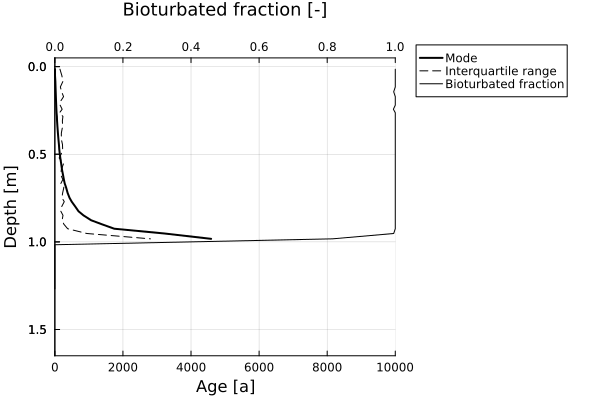

In [137]:
fig_mounding = plot_age_depth_profile(soil_mounding, ages_mounding, 2)
# savefig(fig_mounding,  "BT_mounding.png")
fig_mounding

There are several optional parameters to modify the plot, which can be added after the current parameters. The fourth parameter is a boolean where you can indicate if you want a curve of the IQR or if you want to visualize probability density functions of the luminescence particle ages. This parameter is set to `true` by default, to indicate the plotting of the IQR-curve. By changing it to `false`, the probability functions will be plotted. The fifth parameter indicates how many layers density functions need to be plotted. In the code below, for example, every third layer will be plotted.

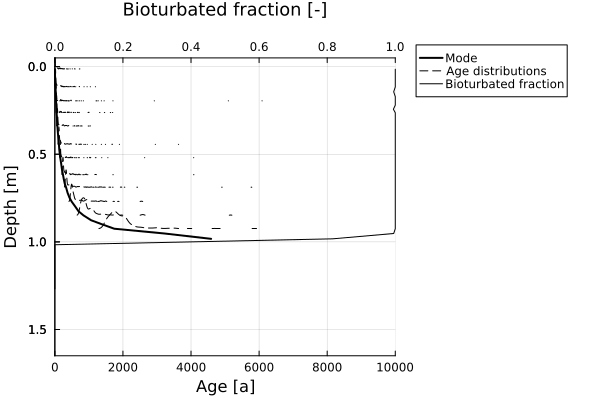

In [138]:
fig_mounding_2 = plot_age_depth_profile(soil_mounding, ages_mounding, 2, false, 3)
fig_mounding_2

## Saving model output
Every simulation run will output an array with information on the layer thicknesses and an array of arrays with the ages of the luminescence particles. These objects can be stored as specific Julia objects with the extension `JLD2` with the function `write_soil_and_age_JLD2()`, which can later be reloaded for further analysis with the function `read_soil_and_age_JLD2()`. The simulation results can also be exported as a .csv file for analysis in other software, with the function `write_soil_and_age_CSV()`. These CSVs can also be reloaded into the soil and age arrays with the function `read_soil_and_age_CSV()`. The required inputs are the soil and ages arrays, a name of the simulated scenario, which will be added to the file name, and an optional folder where the files need to be stored. If this is unspecified, the files will be stored in the folder where this notebook is stored. For the read functions, the directory and file where the objects are stored need to be provided.

In [ ]:
# Exporting simulations as CSV
write_soil_ages_CSV(soil_mounding, ages_mounding, "scenario_name", "folder")

# Importing simulations as CSV
soil, ages = read_soil_ages_CSV("directory_of_soil_file.csv", "directory_of_ages_file.csv")

# Storing simulations as JLD2 file
write_soil_ages_JLD2(soil_mounding, ages_mounding, "scenario_name", "folder")

# Reading simulation stored as JLD2 file
soil, ages = read_soil_ages_JLD2("directory_of_soil_file.csv", "directory_of_ages_file.csv")






## Simulation run with subsurface mixing
Simulations with other bioturbation processes, such as subsurface mixing, follow the same syntax, only with a different function name. The code below simulates subsurface mixing with the same parameters as above. Subsurface mixing requires much more calculation steps, because soil material is exchanged between each layer. The number of layers in the soil profile determines the calculation time, which increases exponentially with the numbers of layers. In the simulations below, subsurface mixing is simulated with a gradational depth profile and depth decay parameter of 6 m⁻¹.

Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


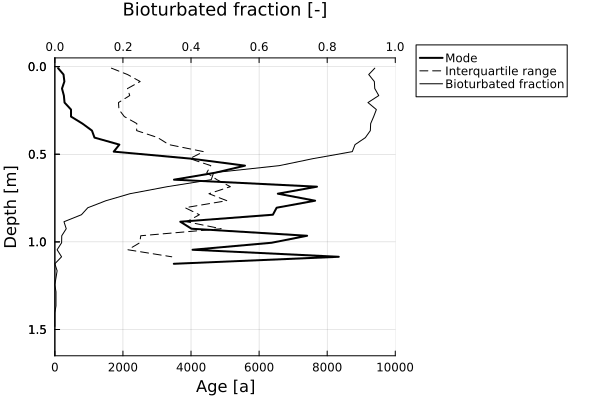

In [140]:
soil_mixing, ages_mixing = initialise_soil(soildepth, nlayers, layer_thickness, bleaching_depth, grains_per_layer)

@showprogress dt=5 for t in 1:ntime
    soil_mixing, ages_mixing = BT_mixing(soil_mixing, ages_mixing, BT_pot, "grd", 6)
    soil_mixing, ages_mixing = update_soil_and_luminescence(soil_mixing, ages_mixing)
end
fig_subsurface_mixing = plot_age_depth_profile(soil_mixing, ages_mixing, 2)
fig_subsurface_mixing


## Simulation run with both mounding and subsurface mixing
Mixed Signals is also able to simulate multiple soil mixing processes simultaneously. To do this, you can add two bioturbation processes in the for-loop and modify their bioturbation rates. The code below simulates both processes, with 25% mounding and 75% subsurface mixing. 

In [141]:
soil_multiple, ages_multiple = initialise_soil(soildepth, nlayers, layer_thickness, bleaching_depth, grains_per_layer)

@showprogress dt=5 for t in 1:ntime
    soil_multiple, ages_multiple = BT_mounding(soil_multiple, ages_multiple, BT_pot * 0.25, "grd", dd)
    soil_multiple, ages_multiple = BT_mixing(soil_multiple, ages_multiple, BT_pot * 0.75, "grd", 6)
    
    soil_multiple, ages_multiple = update_soil_and_luminescence(soil_multiple, ages_multiple)
end


Progress: 100%|█████████████████████████████████████████| Time: 0:08:35


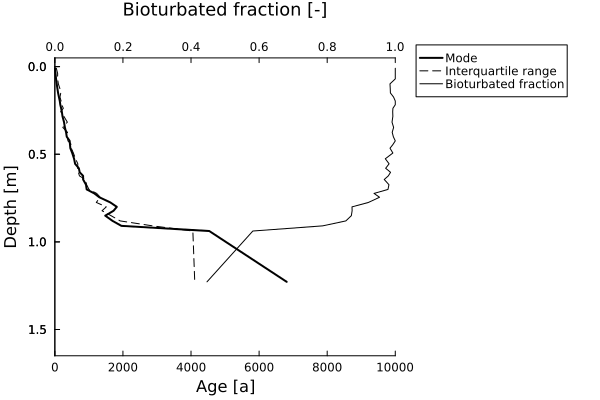

In [152]:
fig_multiple = plot_age_depth_profile(soil_multiple, ages_multiple, 2, true, 1, [0,10000])
fig_multiple

## Runs with varying parameters
The code below can be used to compare simulations with varying parameter settings. These parameter settings are stored in vectors, in this case indicating different depth functions and their corresponding depth decay parameters. All input of the bioturbation functions can be varied. For this, make sure that the varying parameters are defined in a vector and that this vector is indexed and referenced in the corresponding variable position in the bioturbation function. 

In [11]:
# Define the variations in the parameters. Make sure that the depth decay parameters match the depth functions, and that both vectors are of the same length
depthfunctions = ["grd", "exp", "abr"]
depthdecayparameters = [1, 6, 1]

# Create empty, multi-dimensional arrays to store the outputs from the simulations
soil_depthfunction = zeros(Float64, (length(depthfunctions), nlayers, 4))
ages_depthfunction = fill(Int[],(length(depthfunctions), nlayers))

# Iterate over the varying depth functions and run the simulations
for i in eachindex(depthfunctions)
    soil_mounding, ages_mounding = initialise_soil(soildepth, nlayers, layer_thickness, bleaching_depth, grains_per_layer)
    @showprogress dt=5 for t in 1:ntime
        soil_mounding, ages_mounding = BT_mounding(soil_mounding, ages_mounding, BT_pot, depthfunctions[i], depthdecayparameters[i])
        soil_mounding, ages_mounding = update_soil_and_luminescence(soil_mounding, ages_mounding)
    end
    soil_depthfunction[i,:,:] = soil_mounding
    ages_depthfunction[i,:,:] = ages_mounding
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


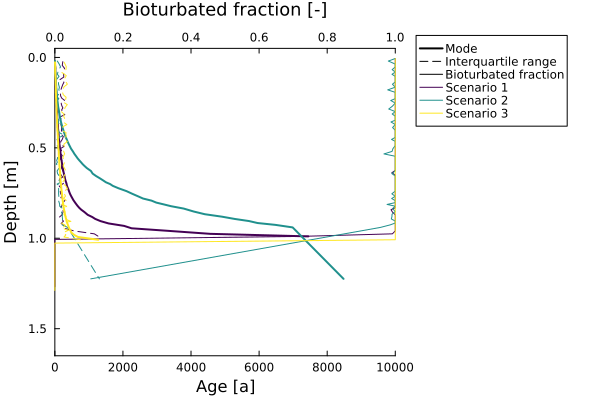

In [15]:

# The plotting works the same as for single simulations, but the different scenarios are indicated with different colors
fig_varyingParameters = plot_age_depth_profile(soil_depthfunction, ages_depthfunction, 2)
fig_varyingParameters

## Calibration of luminescence-based depth curves
To calibrate luminescence-based depth curves, first the calibration data and calibration parameters need to be prepared. 

For the calibration data, create a CSV with all the individual (single-grain) De measurements, for all samples in a soil profile. Include at least the following column names, mind the capitalization. 
- depth (depth of every sample, in meters. This parameter is used to separate the different samples)
- fbio (bioturbated fraction, or non-saturated fraction, value between 0 and 1)
- age (age of the individual De measurements, in years)

After that, set the parameters for the simulations, based on the specific case study. Also define the variation in the different parameters that you want to calibrate. I advice to use larger increments between the different values for a first calibration run and zoom in on the parameter set with the lowest calibration score for a second calibration run, to reduce the number of calculation steps. For parameters that you don't want to calibrate, enter a single value. The function `create_calibration_parameters()` will create a table with all unique combinations of the parameters, which serves as input for the different calibration runs. 

We provided a synthetic dataset for the calibration, named `synthetic_calibration_data.csv`. This dataset is used below to illustrate how the calibration works. It contains five sampling depths, with each 150 age observations. The dataset is created by drawing ages for each sampling depth from a normal distribution. It does not represent any real-life bioturbation dataset and only serves an illustrative purpose. 

In [22]:
# Read the CSV file. Change the directory if necessary.
calibration_data = CSV.read("synthetic_calibration_data.csv", DataFrame)

# Define the variation in the input parameters
cal_depthfunction = ["grd", "abr"] #["grd", "exp", "abr"]
cal_BT_pot = 0.5:0.5:3  # array of values, from 1 with increments of 1 up to 3
cal_active_mixing_depth = 1 # variations in the active mixing zone. The corresponding depth decay parameters will be calculated in the create_calibration_parameters() function
cal_rel_process = 0:.25:1 # relative contribution of subsurface mixing and mounding, ranging from 0 to 1, with increments of 0.2

calib_parameters_and_results = create_calibration_parameters(cal_depthfunction, cal_BT_pot, cal_active_mixing_depth, cal_rel_process)

print(string("Number of calibration runs: ", size(calib_parameters_and_results)[1]))


Number of calibration runs: 60

Now the soil- and luminescence-related parameters for the calibration runs need to be defined. These parameters determine the number of soil layers, and with that, the calculation time. A lower number of layers, with corresponding higher thicknesses will reduce the calculation times substantially. The calibration calculations are performed in parallel, using all the cores on your computer. This will decrease the calculation time, but will also limit the use of your computer for other tasks. Count on several hours of calculation time. The progress bar will appear after a few minutes and give an indication of the remaining time.

The model can calibrate on three metrics: the mode of the age distributions, the interquartile range of the age distributions and the bioturbated fraction. The calibration metrics can be included or excluded by switching the `true` to `false` in the calibration function in the code below. These  boolean operators for the different metrics are in the following order: mode, interquartile range, bioturbated fraction.

In [23]:
# Set parameters for the calibration run
#ntime = 13200-3800      # runtime of the model
ntime = 5000
bd = 1500               # Bulk density [kg m-3]
soildepth = 1.5         # Thickness of the entire soil profile [m]
nlayers = 50            # Number of soil layers
layer_thickness = 0.03  # Initial layer thickness [m]
bleaching_depth = 0.005 # Thickness of surface layer where bleaching occurs [m]
grains_per_layer = 150  # Initial number of layers per soil layer
dd_exch = 10            # Depth parameter for subsurface mixing [m-1]

soil_age_parameters = [ntime, soildepth, nlayers, layer_thickness, bleaching_depth, grains_per_layer, bd, dd_exch]

# Run the calibration
@showprogress dt=5 Threads.@threads for i in 1:size(calib_parameters_and_results)[1]   
    s, a = BT_calibration_run(soil_age_parameters, calib_parameters_and_results, i) # Calculate bioturbation scenario
    calib_parameters_and_results[i,5:8] .= BT_calibration_errors(s, a, calibration_data, true, true, true) # calculate calibration error
end


Progress: 100%|█████████████████████████████████████████| Time: 1:17:03


First, we visualize the calibration error curve. 

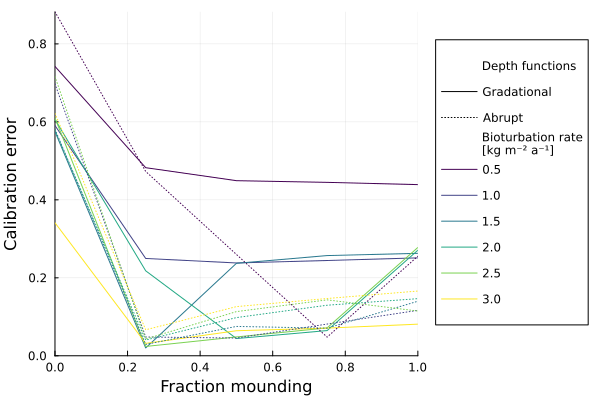

In [24]:
fig_calibrationcurve = plot_calibration_curves(calib_parameters_and_results)
fig_calibrationcurve

Finally, we re-run the best scoring calibration scenario and plot the results with the experimental data. The first code block prints out the parameters of the best performing calibration scenario. The second code block re-runs the best performing scenario and plots the experimental and simulated luminescence-based depth curves.

In [25]:
# Identify run with best parameter, based on the total error
y=calib_parameters_and_results[:,8]
index_calibration = findall(y .== minimum(y))[1]
depthfunctions = ["Gradational", "Exponential", "Abrupt"]

# Print the best calibration parameters
string("Depth function: ", depthfunctions[Int(calib_parameters_and_results[index_calibration,1])],". Bioturbation rate: ", calib_parameters_and_results[index_calibration,2]," kg m⁻² a⁻¹. Percentage mounding: ", calib_parameters_and_results[index_calibration,4]*100, "%")



"Depth function: Gradational. Bioturbation rate: 1.5 kg m⁻² a⁻¹. Percentage mounding: 25.0%"

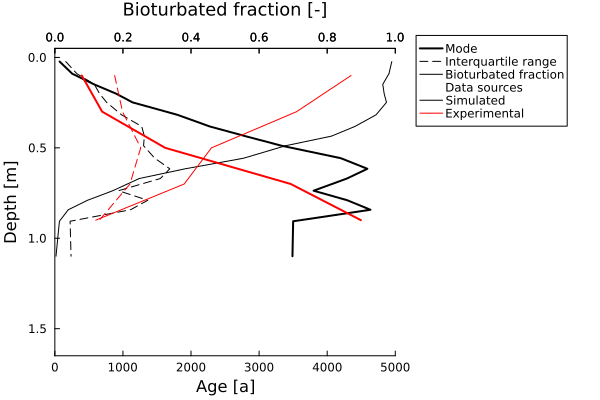

In [26]:
# Re-run the scenario with the lowest error and plot the results with the experimental data
soil_calibration, ages_calibration = BT_run(soil_age_parameters, calib_parameters_and_results, index_calibration)

# Plot the experimental and simulated luminescence-based depth curves
fig_calibration = plot_age_depth_profile(soil_calibration, ages_calibration, 3)
fig_calibration = add_calibration_PDFs(fig_calibration, calibration_data)
fig_calibration